## <p style="text-align: center;">Fine-Tuning a Faster Convolutional Neural Network for Thermal Signature Classification from Infrared Drone Images in Wildlife Conservation</p>

<p style="text-align: center;">Abstract: </p>
<p style="text-align: center;"> This tutorial demonstrates how to effectively fine-tune and evaluate a Faster CNN model (namely the foundational ResNet-18 model) using the birdsai dataset of night time infrared images from drones in Southern Africa. The tutorial starts with how to best set up the data for the fine-tuning, then we explore how hyperparameters affect the models accuracy followed by training and evaluating the model with the best found hyperparameters. The resulting model is one that can be used to classify thermal signatures identified by drones at night time as either being that of a humnan or animal, which can support anti-poaching and conservation efforts. </p>


## Learning Objectives

By completing this tutorial, you will be able to:

- Understand how to carry out transfer learning for thermal signature classification
- Extract thermal signatures from thermal images based off labelled bounding boxes
- Understand the impact of hyperparameters on model accuracy (specifically the learning rate and the trained CNN layers)
- Evaluate model performance for conservation applications

## Table of Contents
1. [Introduction](#introduction)
2. [Environment Setup](#setup)
3. [Data Preparation](#data)
4. [Thermal Signature Extraction](#signatures)
5. [Dataset Creation](#dataset)
6. [Model Architecture](#model)
7. [Training Process](#training)
8. [Hyperparameter Exploration](#hyperparameters)
9. [Evaluation](#evaluation)
10. [Results and Discussion](#results)
11. [References](#references)

<a id="introduction"></a>
## 1. Introduction

Wildlife conservation efforts are increasingly using drones to capture thermal images (Microavia, 2024) to monitor conservation areas at night for poachers and illegal activity. Being able to automatically distinguish humans, which can be potential poachers, from animals provides a unique challenge due to the small thermal signatures of animals and humans that can be obscured by vegetation.

This tutorial applies transfer learning with a pre-trained CNN (ResNet-18) to create an effective classifier for this specialised task. Unlike typical computer vision tutorials that focus on RGB images, our approach addresses thermal imagery's unique characteristics:

- Single-channel (grayscale) thermal data instead of 3-channel RGB
- Small objects of interest (humans/animals) within larger frames

### Why not carry out classification using the entire image?
In short: the thermal signatures are too small.

We explored fine tuning the ResNet-18 CNN model to classify the entire image as either having a human or animal in it but this did not work as well due to the animals or humans representing small objects within the images. It was deduced that the model would try learn the image background which consitutes a large portion of the image instead of focusing on the small human or animal thermal signaturs in the image. Thus, by focusing only on the thermal signatures of the humans and animals the model can learn the to classify the thermal signatures and not the unimportant background. In the real world if used in  thermal image capturing drones this model would require another model to first detect the thermal signatures to then pass the signatures to this model for classification.

Better yet fine tuning a faster RCNN model which can carry out object detection as well as classification would be the best model for deployment in the real world but due to the additional complexity and the desired brevity of this tutorial we just focus on the classification aspect using a faster CNN.

### Comparison with Existing Approaches

This is the first tutorial of its kind in terms of demonstrating how to carry out transfer learning with a pretrained CNN model using thermal signatures.

Looking at other tutorials with similar concepts at a high level of demonstrating how to carry out transfer learning with CNN models on RGB images the following comparison was made:

| Approach | Pros | Cons |
|----------|------|------|
| Transfer learning for Image Classification by PyTroch [(Chilamkurthy, 2025)](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html) | Simple implementation for beginners. Demonstrates both feature extraction and fine-tuning the final fully connected layer.|Neither explores the effect of differing learning rates or dataset class distribtuions. |
| Fine-Tuning for Dog Image classificaton [(Fu, 2023)](https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/) | Provides a comparison of training from scratch vs transfer learning. | Neither explores differing hyperparameters or class distributions in the dataset. |
| Transfer learning for Dog vs Cat Image Classification [(fchollet, 2023)](https://keras.io/guides/transfer_learning/) | Provides a comprehensive introduction to transfer learning and understanding freezing layers. | Does not intuitively visualise model accuracy in graphs. Neither explores differing hyperparameters or dataset class distributions. |
| Fine-Tuning for hand gesture recognition [(Mills, 2024)](https://christianjmills.com/posts/pytorch-train-image-classifier-timm-hf-tutorial/#selecting-a-model) | Provides a comprehensive guide from setting up the python environment to making predictions with the fine-tuned model. Explores available foundational models with emphasis on choosing a task suitable model. | Does not explore the effects of differeing hyperparameters. lacks intuitive graphs for analysing model performance or predictions.  |

Our tutorial improves upon existing approaches by:

1. **Domain-Suitable Model Selection**: Unlike other tutorials that don't address fine-tuning models that can be suitable for deployment in the real world use case, we specifically choose the ResNet-18 model over bigger foundational models due to it's smaller size and greater efficiency which is more suitale for deployment on thermal imaging drones.

2. **Signature-Focused Classification**: We focus on the specific task of thermal signature classification rather than full-frame detection, which is more relevant for real-time wildlife monitoring.

3. **Systematic Hyperparameter Experimentation**: We provide a structured comparison of different hyperparameter setups to deduce an optimal model for thermal signature classification.

4. **Complete End-to-End Pipeline**: Our tutorial covers the entire process from raw thermal image processing to a deployable model, creating a practical guide for conservation applications.

5. **Addresses Data Imbalance**: Our tutorial delves into the data to recognise class distribution imbalances and then creates new datasets with even class distributions to avoid one class from being under represented.

6. **Provides intuitive Visualisations**: Unlike other tutorials we visualise model accuracy changes during training and validation. Additionally we display a confusion matrix as well as test set images and the models classifications of these images along with the models confidence score to provide a more visual evaluation of the models accuracy.

<a id="setup"></a>
## 2. Environment Setup

In [ ]:
# Import libraries
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import json
import cv2
from PIL import Image

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

# For evaluation
from sklearn.metrics import confusion_matrix, classification_report

# Define a device which uses the GPU if available, otherwise the CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

<a id="data"></a>
## 3. Data Preparation

For this tutorial, we're using a subset of the [BirdsAI dataset](https://lila.science/datasets/conservationdrones), which is comprised of thermal images and annotations (labels and bounding boxes) of both humans and a variety of animals.

Prerequisite: To run this tutorial yourself you will need the `birdsai_data` folder which is a curated subset of the [BirdsAI dataset](https://lila.science/datasets/conservationdrones) created for this tutorial. This was done by downloading 500 images comprised of both animl and human classes which where then split into a train, validation and test set (we also created a metadata.json file for information on this curated dataset). Please make contact if you would like this specific curated dataset, otherwise you can access the BirdsAI dataset and curate your own sets.

First lets explore the dataset and check the image class balance to see whether both classes are represented equally in the sets.

In [ ]:
# Define paths
DATA_ROOT = "birdsai_data"
TRAIN_DIR = os.path.join(DATA_ROOT, "train")
VAL_DIR = os.path.join(DATA_ROOT, "val")
TEST_DIR = os.path.join(DATA_ROOT, "test")

# Load metadata file which has information on the data sets
with open(os.path.join(DATA_ROOT, "metadata.json"), "r") as f:
    metadata = json.load(f)

# Display summary statistics
print("Dataset Summary:")
print(f"Total images: {metadata['actual_dataset_size']}")
print(f"Training: {metadata['train_images']} images")
print(f"Validation: {metadata['val_images']} images")
print(f"Test: {metadata['test_images']} images")
print(f"Human images: {metadata['human_images']}")
print(f"Animal images: {metadata['animal_images']}")

We can see that in terms of images across the sets we just about have an even distribution of the two classes. 

Now lets have a look at some of the anotations of the images.

In [ ]:
# Load annotation files
train_annotations = pd.read_csv(os.path.join(TRAIN_DIR, "annotations.csv"))
val_annotations = pd.read_csv(os.path.join(VAL_DIR, "annotations.csv"))
test_annotations = pd.read_csv(os.path.join(TEST_DIR, "annotations.csv"))

# Display first few rows of training annotations
train_annotations.head()

By displaying some of the annotation data it is now evident that for the same frame or image there can be multiple objects. This is the case as each image has at least one animal or human thermal signature. Since we are classifying the thermal signatures we should delve into how many unique thermal signatures there are across both classes in all the images.

### Exploring our Thermal Signature Distribution

In [ ]:
# Check class balance in each split's annotations
def check_class_balance(annotations, split_name):
    class_counts = annotations['class'].value_counts()
    human_count = class_counts.get(1, 0)
    animal_count = class_counts.get(0, 0)
    total = human_count + animal_count
    
    print(f"{split_name} Set Class Distribution:")
    print(f"Human (class 1): {human_count} annotations ({human_count/total:.1%})")
    print(f"Animal (class 0): {animal_count} annotations ({animal_count/total:.1%})")
    print(f"Total: {total} annotations\n")

# Check class balance for each split
check_class_balance(train_annotations, "Training")
check_class_balance(val_annotations, "Validation")
check_class_balance(test_annotations, "Test")

Delving into the number of annotations for each human and animal object we see that the human thermal signatures are under represented across the images. This is not a surprise as animals tend to be in large groups. To ensure that we train a model on an even amount of data across both classes we will need to create new train, validation and test sets with even representaions of both animal and human thermal signatures.

Next, let's examine the distribution of object sizes in our dataset. This will help us understand what sizes of thermal signatures we're dealing with.

In [ ]:
# Calculate object sizes
train_annotations['area'] = train_annotations['w'] * train_annotations['h']

# Create boxplot of object sizes by class
plt.figure(figsize=(10, 6))
sns.boxplot(x='class', y='area', data=train_annotations)
plt.title('Distribution of Object Sizes by Class')
plt.xlabel('Class (0=Animal, 1=Human)')
plt.ylabel('Area (pixels²)')
plt.yscale('log')  # Log scale for better visualisation
plt.show()

# Summary statistics of object sizes
size_stats = train_annotations.groupby('class')['area'].describe()
print("Object Size Statistics:")
print(size_stats)

We can see that the object sizes differ between the two classes as animals (especially elephants which are present in some of the images) tend to be larger than humans. Now that we are aware of the object sizes we can choose a standard area size to extract from the images to represent the thermal signatures across the two classes which is important for passing standardised image sizes to the CNN model.

<a id="signatures"></a>
## 4. Thermal Signature Extraction

Now, let's visualise some examples from our dataset with bounding boxes to show what the thermal images and signatures look like.

Example with Human:


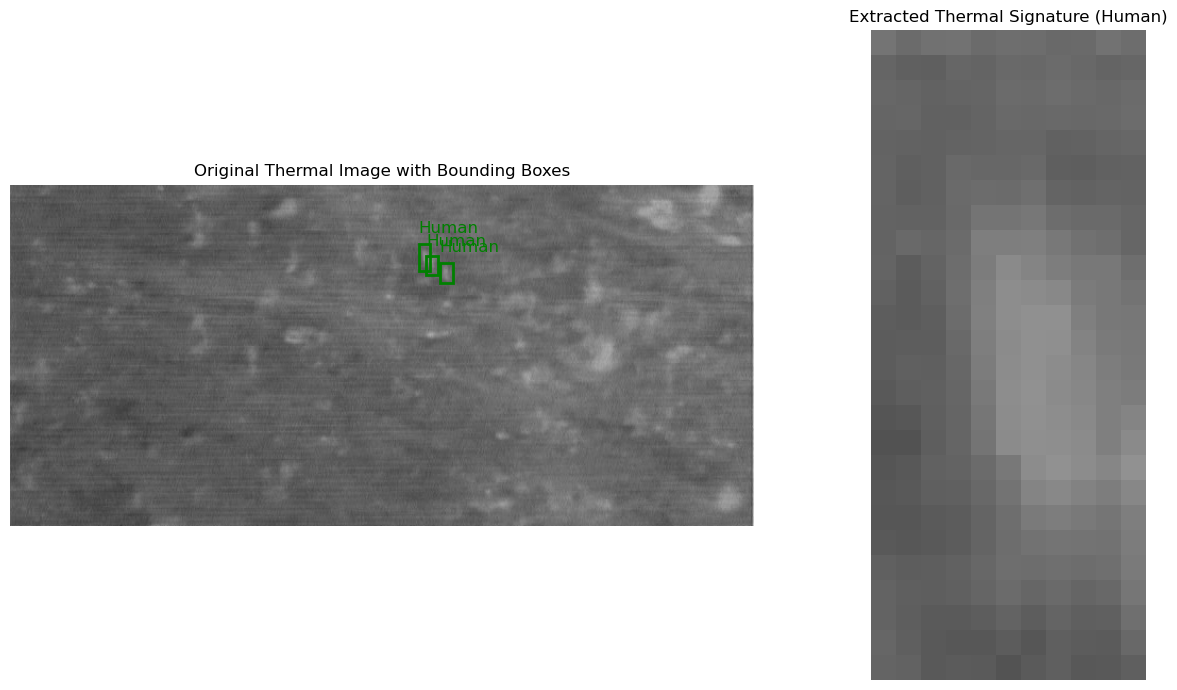


Example with Animal:


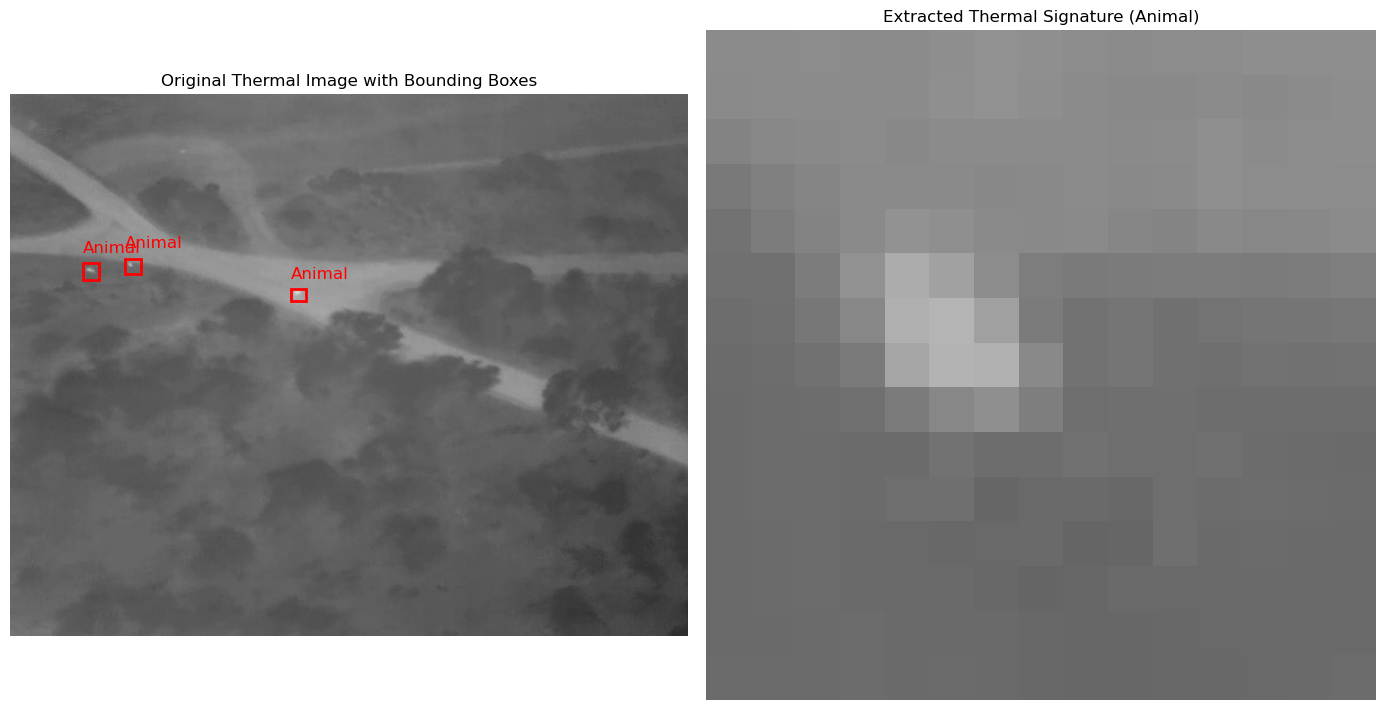

In [44]:
def visualise_thermal_image_with_bbox(split_dir, frame_number, annotations):
    """Visualise thermal image with bounding boxes."""
    # Load image
    img_path = os.path.join(split_dir, "images", f"image_{frame_number:06d}.jpg")
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Get annotations for this frame
    frame_annos = annotations[annotations['frame_number'] == frame_number]
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
    
    # Show original image with bounding boxes
    ax1.imshow(img)
    ax1.set_title('Original Thermal Image with Bounding Boxes')
    ax1.axis('off')
    
    # Colours for different classes
    colors = {0: 'red', 1: 'green'}
    class_names = {0: 'Animal', 1: 'Human'}
    
    # Get first annotation to show as extracted signature
    if len(frame_annos) > 0:
        first_anno = frame_annos.iloc[0]
        x, y, w, h = int(first_anno['x']), int(first_anno['y']), int(first_anno['w']), int(first_anno['h'])
        class_id = int(first_anno['class'])
        
        # Extract and show the thermal signature
        signature = img[y:y+h, x:x+w]
        ax2.imshow(signature)
        ax2.set_title(f'Extracted Thermal Signature ({class_names[class_id]})')
        ax2.axis('off')
    
    # Draw all bounding boxes
    for _, anno in frame_annos.iterrows():
        x, y, w, h = int(anno['x']), int(anno['y']), int(anno['w']), int(anno['h'])
        class_id = int(anno['class'])
        
        rect = plt.Rectangle((x, y), w, h, linewidth=2, 
                           edgecolor=colors[class_id], facecolor='none')
        ax1.add_patch(rect)
        ax1.text(x, y-10, class_names[class_id], color=colors[class_id], fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
# Select an example from training set
# Find one frame with a human
human_example = train_annotations[train_annotations['class'] == 1]['frame_number'].iloc[0]
# Find one frame with an animal
animal_example = train_annotations[train_annotations['class'] == 0]['frame_number'].iloc[0]

# Visualise examples
print("Example with Human:")
visualise_thermal_image_with_bbox(TRAIN_DIR, human_example, train_annotations)

print("\nExample with Animal:")
visualise_thermal_image_with_bbox(TRAIN_DIR, animal_example, train_annotations)

### Extracting Thermal Signatures

Based on the bounding box annotations, we'll extract the thermal signatures (the regions containing humans or animals) and preprocess them for our classifier. We'll resize them to a standard size, normalise the pixel values, and create augmentations.

1. First lets define a function which will locate the object using the bounding box's `x` and `y` pixel locations and the `w` (width) and `h` (height) values, thereafter resizing the area of interest to a standard size using the maximum mean object size we identified the earlier step (`240` squared pixels in this case).

Special Note: `cv2.imread()` loads images in BGR format (3 channels) by default so we convert it back to grayscale (1 channel) where later we will repeat this single channel into 3 identical channels as the foundational CNN model works with `3 channel inputs`.

In [ ]:
def extract_thermal_signature(img_path, x, y, w, h, target_size=(240, 240)):
    """Extract thermal signature from an image given bounding box coordinates."""
    # Read image
    img = cv2.imread(img_path)
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Extract signature using bounding box
    signature = gray[y:y+h, x:x+w]
    
    # Resize to target size
    signature_resized = cv2.resize(signature, target_size)
    
    # Convert to PIL (Python Imaging Library) image for PyTorch transformations
    signature_pil = Image.fromarray(signature_resized)
    
    return signature_pil

2. Lets test this function by visualising some examples

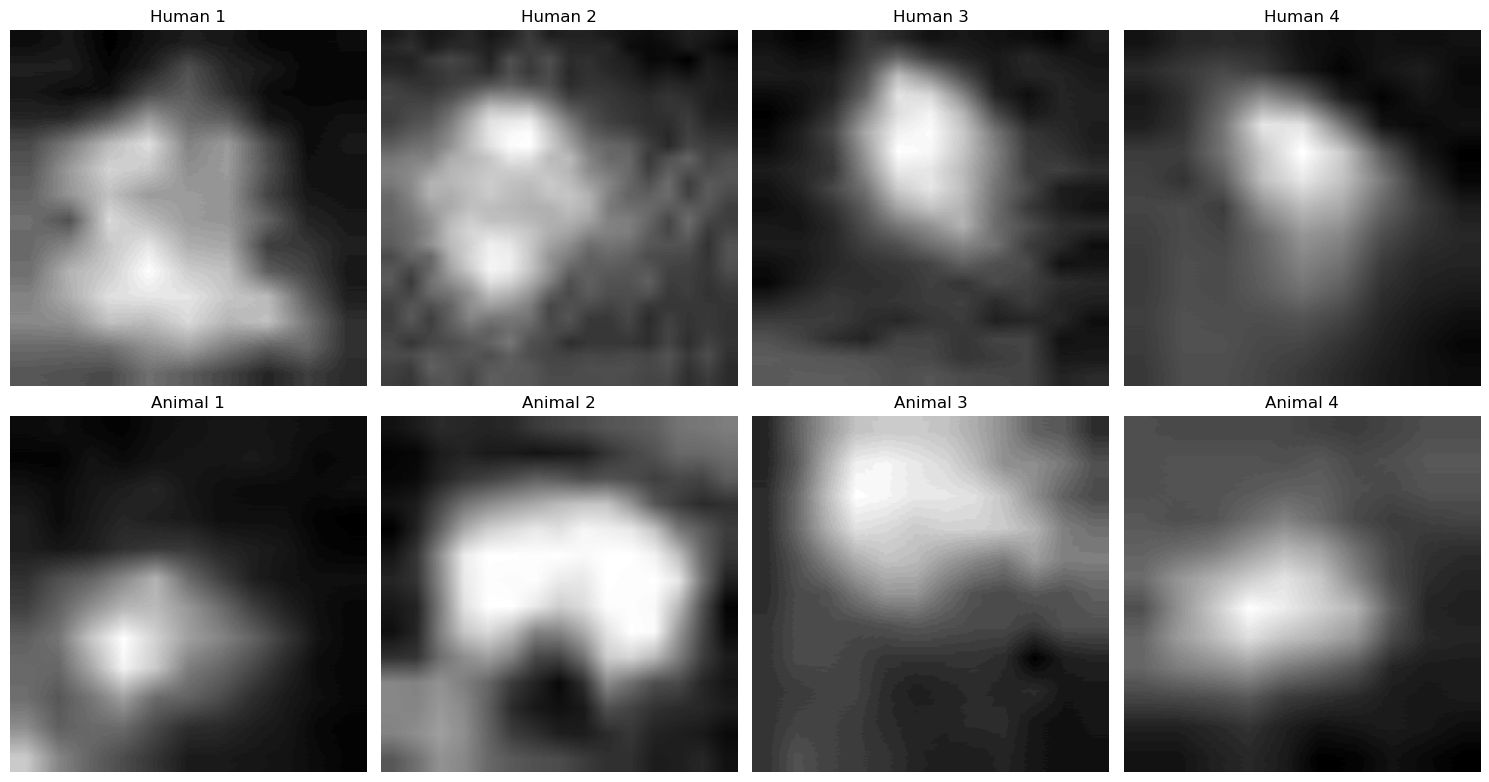

In [ ]:
def process_examples(frames, class_name, axes_row, split_dir, axes):
    for i, (_, anno) in enumerate(frames.iterrows()):
        frame_num = anno['frame_number']
        img_path = os.path.join(split_dir, "images", f"image_{int(frame_num):06d}.jpg")
        x, y, w, h = int(anno['x']), int(anno['y']), int(anno['w']), int(anno['h'])
        
        signature = extract_thermal_signature(img_path, x, y, w, h)
        axes[axes_row, i].imshow(signature, cmap='gray')
        axes[axes_row, i].set_title(f"{class_name} {i+1}")
        axes[axes_row, i].axis('off')

def show_extracted_signatures(split_dir, annotations, number_of_examples=3):
    # Get some human examples
    human_frames = annotations[annotations['class'] == 1].sample(number_of_examples)
    # Get some animal examples
    animal_frames = annotations[annotations['class'] == 0].sample(number_of_examples)
    
    fig,axes = plt.subplots(2, number_of_examples, figsize=(15, 8))
    
    # Process human examples
    process_examples(human_frames, "Human", 0, split_dir, axes)
    
    # Process animal examples
    process_examples(animal_frames, "Animal", 1, split_dir, axes)
    
    plt.tight_layout()
    plt.show()

# Show examples of extracted signatures
show_extracted_signatures(TRAIN_DIR, train_annotations, number_of_examples=4)

One key noticable difference between the human and animal thermal signatures is the shape and orientation. We will randomly rotate the images in our training data to create a more diverse thermal signature orientations to help our model generalise better. 

<a id="dataset"></a>
## 5. Dataset Creation

Now, we'll create a PyTorch dataset class to load and preprocess our thermal signatures. This will handle the extraction of signatures from the original images and apply appropriate transformations.

1. Define the dataset class

In [ ]:
class ThermalSignatureDataset(Dataset):
    def __init__(self, annotations, base_dir, transform=None):
        self.annotations = annotations
        self.base_dir = base_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, idx):
        anno = self.annotations.iloc[idx]
        
        # Get image path
        frame_num = anno['frame_number']
        img_path = os.path.join(self.base_dir, "images", f"image_{int(frame_num):06d}.jpg")
        
        # Extract signature
        x, y, w, h = int(anno['x']), int(anno['y']), int(anno['w']), int(anno['h'])
        signature = extract_thermal_signature(img_path, x, y, w, h)
        
        # Apply transformations
        if self.transform:
            signature = self.transform(signature)
        
        # Get label
        label = int(anno['class'])
        
        return signature, label

2. Define transformations

We augment the training data thermal signatures by applying random rotations to create more `diverse orientations` of the thermal signatures to help our model learn more generalisable features.
Additionally due to the foundational CNN model being trained on RGB images (3 channels), we need to format our images to have `3 channels` by tripling the single channel we to ensure our images can be passed to the model. We do this by utilising the `Repeat()` function.

In [ ]:
# For training, we'll include data augmentation
train_transform = transforms.Compose([
    transforms.Resize((240, 240)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229]),  # Single channel normalisation
    transforms.Lambda(lambda x: x.repeat(3, 1, 1))  # Repeat grayscale to 3 channels for the model which accepts 3 channel inputs
])

# For validation and testing, we'll just resize and normalise
val_test_transform = transforms.Compose([
    transforms.Resize((240, 240)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229]),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1))
])

3. We need to create balanced train, validation and test sets in terms of thermal signature distribution across the two classes. We define a function below to create sets of images which have an even distribution of the number annotations for each class:

In [ ]:
def create_balanced_datasets(train_annotations, val_annotations, test_annotations):
    # For training set
    train_humans = train_annotations[train_annotations['class'] == 1]
    train_animals = train_annotations[train_annotations['class'] == 0]
    
    # Calculate how many samples to use (use the smaller class count)
    train_sample_size = min(len(train_humans), len(train_animals))
    
    # Sample equal numbers from each class
    if len(train_humans) > train_sample_size:
        train_humans = train_humans.sample(train_sample_size, random_state=42)
    if len(train_animals) > train_sample_size:
        train_animals = train_animals.sample(train_sample_size, random_state=42)
    
    # Combine and shuffle
    balanced_train = pd.concat([train_humans, train_animals]).sample(frac=1, random_state=42)
    
    # Repeat for validation and test sets
    val_humans = val_annotations[val_annotations['class'] == 1]
    val_animals = val_annotations[val_annotations['class'] == 0]
    val_sample_size = min(len(val_humans), len(val_animals))
    
    if len(val_humans) > val_sample_size:
        val_humans = val_humans.sample(val_sample_size, random_state=42)
    if len(val_animals) > val_sample_size:
        val_animals = val_animals.sample(val_sample_size, random_state=42)
    
    balanced_val = pd.concat([val_humans, val_animals]).sample(frac=1, random_state=42)
    
    test_humans = test_annotations[test_annotations['class'] == 1]
    test_animals = test_annotations[test_annotations['class'] == 0]
    test_sample_size = min(len(test_humans), len(test_animals))
    
    if len(test_humans) > test_sample_size:
        test_humans = test_humans.sample(test_sample_size, random_state=42)
    if len(test_animals) > test_sample_size:
        test_animals = test_animals.sample(test_sample_size, random_state=42)
    
    balanced_test = pd.concat([test_humans, test_animals]).sample(frac=1, random_state=42)
    
    # Display class balance information
    print("Original vs Balanced Datasets:")
    print(f"Training: {len(train_annotations)} → {len(balanced_train)} annotations")
    print(f"  Original: {sum(train_annotations['class'] == 1)} humans, {sum(train_annotations['class'] == 0)} animals")
    print(f"  Balanced: {sum(balanced_train['class'] == 1)} humans, {sum(balanced_train['class'] == 0)} animals")
    
    print(f"Validation: {len(val_annotations)} → {len(balanced_val)} annotations")
    print(f"  Original: {sum(val_annotations['class'] == 1)} humans, {sum(val_annotations['class'] == 0)} animals")
    print(f"  Balanced: {sum(balanced_val['class'] == 1)} humans, {sum(balanced_val['class'] == 0)} animals")
    
    print(f"Test: {len(test_annotations)} → {len(balanced_test)} annotations")
    print(f"  Original: {sum(test_annotations['class'] == 1)} humans, {sum(test_annotations['class'] == 0)} animals") 
    print(f"  Balanced: {sum(balanced_test['class'] == 1)} humans, {sum(balanced_test['class'] == 0)} animals")
    
    return balanced_train, balanced_val, balanced_test

4. Create the datasets of images with even sums of class annotation

In [ ]:
balanced_train, balanced_val, balanced_test = create_balanced_datasets(
    train_annotations, val_annotations, test_annotations
)

5. Creat the final datasets with the extracted and processed thermal signatures

In [ ]:
train_dataset = ThermalSignatureDataset(balanced_train, TRAIN_DIR, transform=train_transform)
val_dataset = ThermalSignatureDataset(balanced_val, VAL_DIR, transform=val_test_transform)
test_dataset = ThermalSignatureDataset(balanced_test, TEST_DIR, transform=val_test_transform)

6. Create data loaders

In [ ]:
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

We have now created our datasets with even class distributions ready for model training, evaluation and testing.

<a id="model"></a>
## 6. Model Architecture

For our classification task, we'll use transfer learning with a pre-trained ResNet-18 CNN model supported by PyTorch for our binary thermal signature classification task (human vs animal).

### Transfer Learning Approaches

For our model, two approaches of transfer learning are explored:

1. **Frozen Backbone**: 
   - In this approach, we keep the pre-trained weights of the convolutional layers (the "backbone") fixed
   - We only train the new classification layers we add
   - This approach is faster to train as minimal layers are trained
   - Performs well when the images we input to the model are similar to the images that were used to train the foundational model (unlikely in our case).

2. **Fine-tuned Backbone**:
   - We update all layers of the backbone during training on our thermal signatures which allows the model to adapt to our thermal signatures
   - Requires more training time

The ideal approach depends on the specific dataset and task. We'll compare both to determine which works better for thermal signature classification.

Lets define a `create_model()` function which will instantiate our foundational ResNet-18 model given the `freeze_layers` parameter which will either freeze or unfreeze the backbone:

In [ ]:
def create_model(freeze_layers=True):
    """Create a CNN model using transfer learning."""
    model = models.resnet18(pretrained=True)
    
    # Freeze all layers if required
    if freeze_layers:
        for param in model.parameters():
            param.requires_grad = False
    
    # Modify the final layer for binary classification
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 256),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(256, 2)  # 2 classes: human and animal
    )
    
    return model

# Create model
model = create_model()
model = model.to(device)

# Print model architecture summary
print(model)

<a id="training"></a>
## 7. Training Process

We'll now define our training process. This includes setting up the loss function, optimiser, and learning rate scheduler, as well as functions for training and evaluation.

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimiser, scheduler=None, 
                num_epochs=10, patience=3):
    """Train the model and return training history."""
    # To store training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }
    
    # For early stopping
    best_val_loss = float('inf')
    early_stop_counter = 0
    best_model_weights = None
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in tqdm(train_loader, desc="Training"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Zero the parameter gradients
            optimiser.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimiser.step()
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        if scheduler is not None:
            scheduler.step()
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc.item())
        
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        
        # Validation phase
        model.eval()
        running_loss = 0.0
        running_corrects = 0
        
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validation"):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Forward pass
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / len(val_loader.dataset)
        epoch_acc = running_corrects.double() / len(val_loader.dataset)
        
        history['val_loss'].append(epoch_loss)
        history['val_acc'].append(epoch_acc.item())
        
        print(f'Val Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        
        # Save best model
        if epoch_loss < best_val_loss:
            best_val_loss = epoch_loss
            best_model_weights = model.state_dict().copy()
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print(f'Early stopping triggered after epoch {epoch+1}')
                break
    
    # Load best model weights
    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)
    
    return model, history

Lets test our training setup by training a model with a frozen backbone (from model instatiation two blocks up) and a learning rate of 0.001 over 20 epochs.

In [39]:
# Set up loss function and optimiser
criterion = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimiser, step_size=7, gamma=0.1)

# Train the model
model, history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimiser=optimiser,
    scheduler=scheduler,
    num_epochs=20,
    patience=5
)

Train Loss: 0.4774 Acc: 0.7734


Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Val Loss: 0.3148 Acc: 0.8553
Epoch 8/20
----------


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.3711 Acc: 0.8531


Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Val Loss: 0.2819 Acc: 0.8553
Epoch 9/20
----------


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.3833 Acc: 0.8187


Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Val Loss: 0.2795 Acc: 0.8618
Epoch 10/20
----------


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.3529 Acc: 0.8484


Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Val Loss: 0.2775 Acc: 0.8487
Epoch 11/20
----------


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.3735 Acc: 0.8266


Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Val Loss: 0.2806 Acc: 0.8487
Epoch 12/20
----------


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.3687 Acc: 0.8328


Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Val Loss: 0.2766 Acc: 0.8684
Epoch 13/20
----------


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.3566 Acc: 0.8297


Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Val Loss: 0.2683 Acc: 0.8553
Epoch 14/20
----------


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.3386 Acc: 0.8438


Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Val Loss: 0.2670 Acc: 0.8684
Epoch 15/20
----------


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.3732 Acc: 0.8266


Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Val Loss: 0.2639 Acc: 0.8618
Epoch 16/20
----------


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.3675 Acc: 0.8344


Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Val Loss: 0.2739 Acc: 0.8553
Epoch 17/20
----------


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.3660 Acc: 0.8313


Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Val Loss: 0.2703 Acc: 0.8487
Epoch 18/20
----------


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.3562 Acc: 0.8281


Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Val Loss: 0.2701 Acc: 0.8618
Epoch 19/20
----------


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.3660 Acc: 0.8281


Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Val Loss: 0.2703 Acc: 0.8684
Epoch 20/20
----------


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.3633 Acc: 0.8328


Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Val Loss: 0.2705 Acc: 0.8750
Early stopping triggered after epoch 20


Now lets visualise how the model performed during training by plotting the train and validation set loss and accuracy scores against the number of epochs.

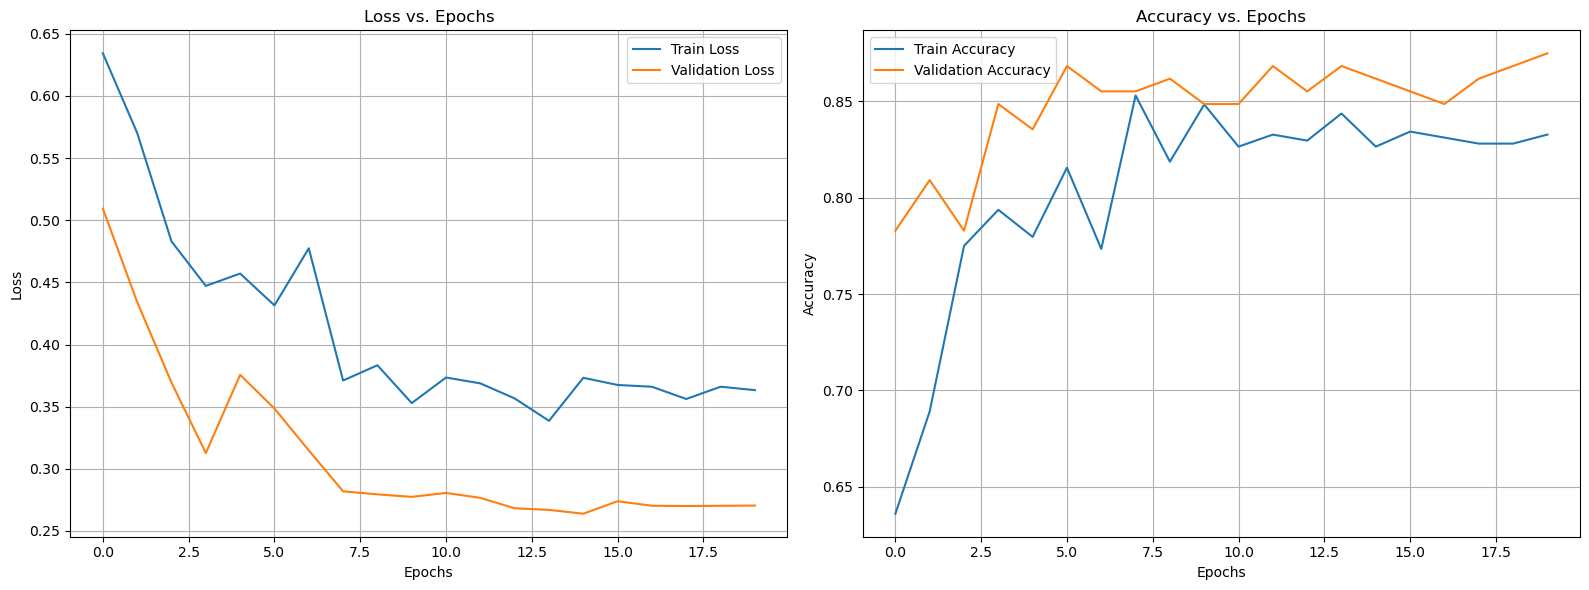

In [40]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot loss
ax1.plot(history['train_loss'], label='Train Loss')
ax1.plot(history['val_loss'], label='Validation Loss')
ax1.set_title('Loss vs. Epochs')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Plot accuracy
ax2.plot(history['train_acc'], label='Train Accuracy')
ax2.plot(history['val_acc'], label='Validation Accuracy')
ax2.set_title('Accuracy vs. Epochs')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

Looking at the plots we see the following: 
- The model's loss decreases and the accuracy increases for the validation set as we progress through the epochs which indicates that our model is learning!
- The metrics stabalise after epoch 7, suggesting that past this epoch we don't see any great improvement (due to the small dataset)
- A consistent gap between the train (blue) and validation (orange) performance which can be attributed to the difference in data augmentation and highlights that our model performs better on the validation data which is unusual but great.

<a id="hyperparameters"></a>
## 8. Hyperparameter Exploration

Now, let's compare how different hyperparameters affect model performance. We'll explore two key hyperparameters: the learning rate and the convolutionsal layer weights.

By looking at the configs array we have defined four different hyperparameter setups which we wll use to train four models which we will evaluate.

In [45]:
def experiment_with_hyperparams():
    """Run experiments with different hyperparameters."""
    # Define hyperparameter configurations to test
    configs = [
        {
            'name': 'Frozen Backbone + High LR',
            'freeze_layers': True,
            'learning_rate': 0.001,
            'color': 'blue'
        },
        {
            'name': 'Frozen Backbone + Low LR',
            'freeze_layers': True,
            'learning_rate': 0.0001,
            'color': 'green'
        },
        {
            'name': 'Fine-tuned Backbone + Low LR',
            'freeze_layers': False,
            'learning_rate': 0.0001,
            'color': 'red'
        },
        {
            'name': 'Fine-tuned Backbone + High LR',
            'freeze_layers': False,
            'learning_rate': 0.001,
            'color': 'purple'
        }
    ]
    
    results = []
    
    for config in configs:
        print(f"\nTraining with configuration: {config['name']}")
        print("-" * 40)
        
        # Create model with specified freezing strategy
        model = create_model(freeze_layers=config['freeze_layers'])
        model = model.to(device)
        
        # Set up optimiser with specified learning rate
        optimiser = optim.Adam(model.parameters(), lr=config['learning_rate'])
        scheduler = optim.lr_scheduler.StepLR(optimiser, step_size=7, gamma=0.1)
        
        # Train for a fixed number of epochs to enable fair comparison
        model, history = train_model(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            criterion=criterion,
            optimiser=optimiser,
            scheduler=scheduler,
            num_epochs=10,  # Fixed number of epochs for comparison
            patience=100    # High patience to ensure all epochs run
        )
        
        # Store results
        results.append({
            'config': config,
            'history': history,
            'model': model
        })
    
    return results

# Run hyperparameter experiments
hyperparam_results = experiment_with_hyperparams()


Training with configuration: Frozen Backbone + High LR
----------------------------------------
Epoch 1/10
----------


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.6350 Acc: 0.6281


Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Val Loss: 0.4720 Acc: 0.7829
Epoch 2/10
----------


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.5083 Acc: 0.7547


Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Val Loss: 0.4211 Acc: 0.8026
Epoch 3/10
----------


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.5078 Acc: 0.7547


Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Val Loss: 0.3360 Acc: 0.8487
Epoch 4/10
----------


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.4521 Acc: 0.7844


Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Val Loss: 0.3000 Acc: 0.8355
Epoch 5/10
----------


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.4548 Acc: 0.7672


Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Val Loss: 0.2911 Acc: 0.8618
Epoch 6/10
----------


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.3977 Acc: 0.8266


Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Val Loss: 0.3011 Acc: 0.8684
Epoch 7/10
----------


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.3999 Acc: 0.8172


Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Val Loss: 0.2530 Acc: 0.8684
Epoch 8/10
----------


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.3727 Acc: 0.8297


Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Val Loss: 0.2654 Acc: 0.8882
Epoch 9/10
----------


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.3949 Acc: 0.8219


Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Val Loss: 0.2621 Acc: 0.8816
Epoch 10/10
----------


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.3890 Acc: 0.8109


Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Val Loss: 0.2548 Acc: 0.8750

Training with configuration: Frozen Backbone + Low LR
----------------------------------------
Epoch 1/10
----------


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.6519 Acc: 0.6438


Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Val Loss: 0.5916 Acc: 0.7697
Epoch 2/10
----------


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.6052 Acc: 0.6766


Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Val Loss: 0.5130 Acc: 0.7829
Epoch 3/10
----------


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.5541 Acc: 0.7531


Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Val Loss: 0.4559 Acc: 0.7895
Epoch 4/10
----------


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.5235 Acc: 0.7641


Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Val Loss: 0.4360 Acc: 0.7763
Epoch 5/10
----------


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.5032 Acc: 0.7641


Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Val Loss: 0.4089 Acc: 0.7763
Epoch 6/10
----------


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.4809 Acc: 0.7828


Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Val Loss: 0.3979 Acc: 0.7697
Epoch 7/10
----------


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.4543 Acc: 0.7812


Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Val Loss: 0.3735 Acc: 0.8026
Epoch 8/10
----------


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.4616 Acc: 0.7797


Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Val Loss: 0.3736 Acc: 0.8026
Epoch 9/10
----------


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.4413 Acc: 0.7875


Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Val Loss: 0.3693 Acc: 0.7895
Epoch 10/10
----------


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.4398 Acc: 0.7953


Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Val Loss: 0.3695 Acc: 0.8158

Training with configuration: Fine-tuned Backbone + Low LR
----------------------------------------
Epoch 1/10
----------


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.4019 Acc: 0.8125


Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Val Loss: 0.2165 Acc: 0.9145
Epoch 2/10
----------


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.1522 Acc: 0.9422


Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Val Loss: 0.2523 Acc: 0.8882
Epoch 3/10
----------


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.1999 Acc: 0.9266


Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Val Loss: 0.1068 Acc: 0.9737
Epoch 4/10
----------


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.1112 Acc: 0.9641


Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Val Loss: 0.0789 Acc: 0.9539
Epoch 5/10
----------


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.0747 Acc: 0.9734


Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Val Loss: 0.0716 Acc: 0.9803
Epoch 6/10
----------


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.0710 Acc: 0.9688


Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Val Loss: 0.1620 Acc: 0.9408
Epoch 7/10
----------


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.0825 Acc: 0.9672


Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Val Loss: 0.1320 Acc: 0.9276
Epoch 8/10
----------


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.0522 Acc: 0.9844


Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Val Loss: 0.0767 Acc: 0.9605
Epoch 9/10
----------


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.0697 Acc: 0.9719


Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Val Loss: 0.0708 Acc: 0.9605
Epoch 10/10
----------


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.0386 Acc: 0.9875


Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Val Loss: 0.0565 Acc: 0.9671

Training with configuration: Fine-tuned Backbone + High LR
----------------------------------------
Epoch 1/10
----------


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.5095 Acc: 0.7984


Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Val Loss: 0.6435 Acc: 0.8487
Epoch 2/10
----------


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.3573 Acc: 0.8469


Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Val Loss: 0.2795 Acc: 0.9145
Epoch 3/10
----------


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.3163 Acc: 0.8734


Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Val Loss: 0.7411 Acc: 0.8026
Epoch 4/10
----------


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.2962 Acc: 0.8844


Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Val Loss: 0.4121 Acc: 0.8158
Epoch 5/10
----------


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.2472 Acc: 0.9094


Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Val Loss: 0.1837 Acc: 0.9474
Epoch 6/10
----------


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.2297 Acc: 0.9203


Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Val Loss: 0.2197 Acc: 0.9211
Epoch 7/10
----------


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.1675 Acc: 0.9313


Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Val Loss: 1.2561 Acc: 0.7566
Epoch 8/10
----------


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.1433 Acc: 0.9547


Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Val Loss: 0.2446 Acc: 0.9474
Epoch 9/10
----------


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.1388 Acc: 0.9547


Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Val Loss: 0.1116 Acc: 0.9539
Epoch 10/10
----------


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.1351 Acc: 0.9531


Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Val Loss: 0.1050 Acc: 0.9539


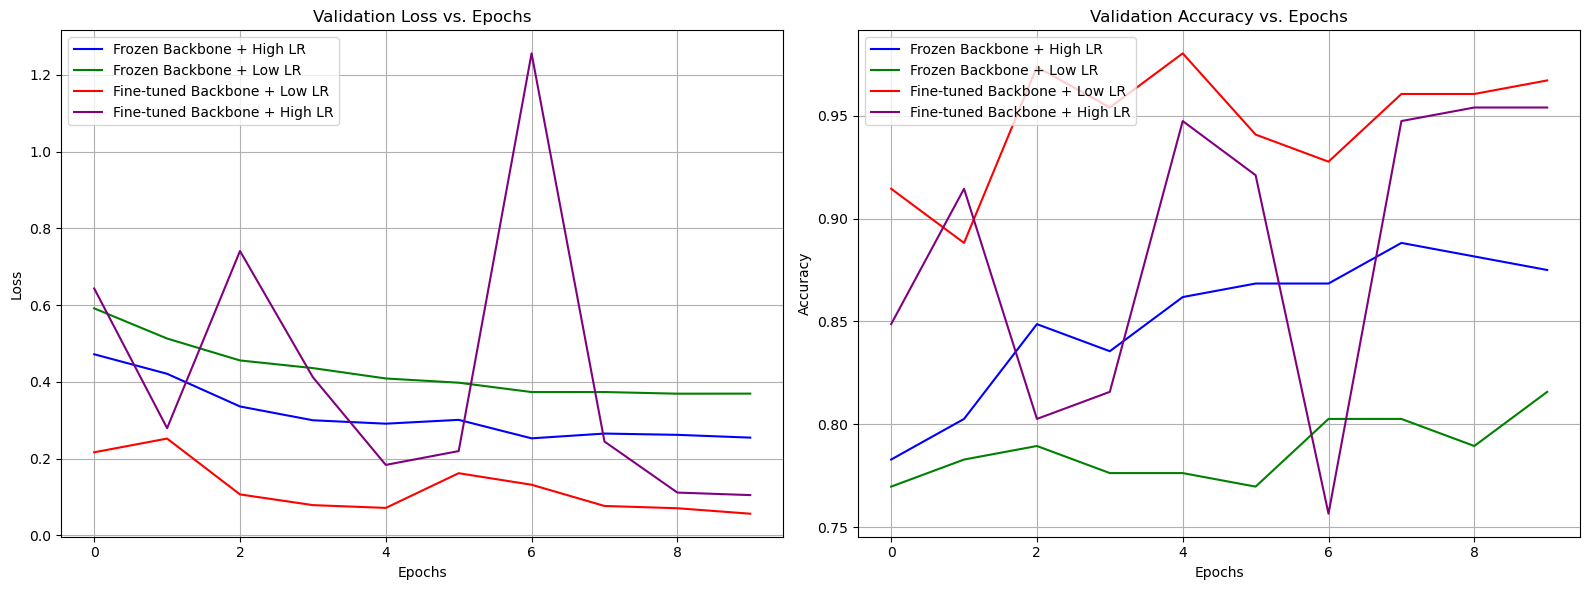

In [46]:
# Plot comparative results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot validation loss
for result in hyperparam_results:
    config = result['config']
    history = result['history']
    ax1.plot(history['val_loss'], label=config['name'], color=config['color'])

ax1.set_title('Validation Loss vs. Epochs')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Plot validation accuracy
for result in hyperparam_results:
    config = result['config']
    history = result['history']
    ax2.plot(history['val_acc'], label=config['name'], color=config['color'])

ax2.set_title('Validation Accuracy vs. Epochs')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

Looking at these graphs it is evident that the model in which we use a low learning rate and fine tune the model layers results in a better model. This happens as when we keep the foundational model layers frozen it is using what it has learned from the RGB images it was trained on so it doesn't work so well with our thermal images which are not RGB. Thus by unfreezing these layers and training them on our thermal images with a slower learning rate the model learns to better handle our thermal images.

In [ ]:
# Create comparison table
comparison_data = []

for result in hyperparam_results:
    config = result['config']
    history = result['history']
    
    # Get final metrics
    final_train_loss = history['train_loss'][-1]
    final_val_loss = history['val_loss'][-1]
    final_train_acc = history['train_acc'][-1]
    final_val_acc = history['val_acc'][-1]
    
    # Get best validation accuracy and its epoch
    best_val_acc = max(history['val_acc'])
    best_epoch = history['val_acc'].index(best_val_acc) + 1
    
    comparison_data.append({
        'Configuration': config['name'],
        'Learning Rate': config['learning_rate'],
        'Freezing Strategy': 'Frozen Backbone' if config['freeze_layers'] else 'Fine-tuned Backbone',
        'Final Train Loss': final_train_loss,
        'Final Val Loss': final_val_loss,
        'Final Train Acc': final_train_acc,
        'Final Val Acc': final_val_acc,
        'Best Val Acc': best_val_acc,
        'Best Epoch': best_epoch
    })

# Create DataFrame and display
comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df[['Configuration', 'Learning Rate', 'Freezing Strategy', 
                               'Final Train Loss', 'Final Val Loss', 'Final Train Acc', 
                               'Final Val Acc', 'Best Val Acc', 'Best Epoch']]

# Format numeric columns
for col in ['Final Train Loss', 'Final Val Loss', 'Final Train Acc', 'Final Val Acc', 'Best Val Acc']:
    comparison_df[col] = comparison_df[col].apply(lambda x: f"{x:.4f}")

comparison_df

### Analysis of Hyperparameter Effects

From our experiments, we can observe the impact of two key hyperparameter choices:

1. **Model Freezing Strategy:**
   - Freezing the backbone (using only pre-trained features) results in a model which has a higher validation set loss score and lower accuracy score as it does not cater to our 
   thermal signature images as well as fine-tuning the layers on our thermal images. 
   - We can see that the freezing stratgey and learning rate go hand-in-hand and that different learning rates impact both freezing strategies differently.

2. **Learning Rate:**
   - A higher learning rate works best with the frozen backbone.
   - A lower learning rate works best with the fine tuned backbone as it can help prevent 'overstepping'.

Based on the results above, we'll continue with the best-performing configuration for our final evaluation, in this case the model that used a lower learning rate along with fine-tuning the backbone.

<a id="evaluation"></a>
## 9. Evaluation

Now that we've identified the best hyperparameters, let's evaluate our model on the test set to assess its real-world performance.

In [ ]:
def evaluate_model(model, test_loader):
    """Evaluate model on test set and return predictions and metrics."""
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            probs = F.softmax(outputs, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    
    # Calculate accuracy
    accuracy = np.mean(all_preds == all_labels)
    
    return all_preds, all_labels, all_probs, accuracy

# Select the best model from our hyperparameter experiments
best_model_idx = np.argmax([result['history']['val_acc'][-1] for result in hyperparam_results])
best_model = hyperparam_results[best_model_idx]['model']
best_config = hyperparam_results[best_model_idx]['config']

print(f"Best configuration: {best_config['name']}")

# Evaluate on test set
preds, labels, probs, accuracy = evaluate_model(best_model, test_loader)
print(f"Test Accuracy: {accuracy:.4f}")

In [ ]:
# Generate confusion matrix
cm = confusion_matrix(labels, preds)
class_names = ['Animal', 'Human']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
report = classification_report(labels, preds, target_names=class_names)
print("Classification Report:")
print(report)

By analysing this confusion matrix we can see that our model classified our thermal signatures to a high degree of accuracy. While the model misclassified one thermal signature as an animal and 2 signatures as a human this level of accuracy can allow anti-poaching units to be efficiently sent out to assess a scene where a human is detected.

### Visualising Predictions

Let's visualise some of the predictions where the model classified correctly and incorrectly across both classes.

In [ ]:
def visualise_predictions(model, test_dataset, test_loader, num_examples=8):
    """Visualise model predictions on test data."""
    model.eval()
    all_preds = []
    all_labels = []
    all_indices = []
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            batch_indices = list(range(i * test_loader.batch_size, 
                                      min((i + 1) * test_loader.batch_size, len(test_dataset))))
            inputs = inputs.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_indices.extend(batch_indices)
    
    # Find examples of different prediction scenarios
    correct_human = []
    correct_animal = []
    incorrect_human = []  # Actually human, predicted as animal
    incorrect_animal = []  # Actually animal, predicted as human
    
    for idx, pred, label in zip(all_indices, all_preds, all_labels):
        if pred == label == 1:  # Correct human
            correct_human.append(idx)
        elif pred == label == 0:  # Correct animal
            correct_animal.append(idx)
        elif pred == 0 and label == 1:  # Actually human, predicted as animal
            incorrect_human.append(idx)
        elif pred == 1 and label == 0:  # Actually animal, predicted as human
            incorrect_animal.append(idx)
    
    # Randomly select from each category
    example_indices = []
    categories = [(correct_human, "Correct Human"), (correct_animal, "Correct Animal"), 
                  (incorrect_human, "Incorrect Human"), (incorrect_animal, "Incorrect Animal")]
    
    for category, label in categories:
        if category:
            selected = random.sample(category, min(num_examples // 4, len(category)))
            example_indices.extend([(idx, label) for idx in selected])
    
    # Calculate proper grid dimensions
    total_examples = len(example_indices)
    if total_examples == 0:
        print("No examples to display!")
        return
        
    # Decide on a reasonable grid layout
    if total_examples <= 4:
        n_cols = total_examples
        n_rows = 1
    else:
        n_cols = 4  # Fixed number of columns
        n_rows = (total_examples + n_cols - 1) // n_cols  # Ceiling division
    
    # Visualise selected examples
    fig = plt.figure(figsize=(15, 12))
    for i, (idx, category) in enumerate(example_indices):
        if i >= n_rows * n_cols:  # Safety check
            break
            
        img, label = test_dataset[idx]
        
        # Make prediction
        with torch.no_grad():
            input_tensor = img.unsqueeze(0).to(device)
            output = model(input_tensor)
            _, pred = torch.max(output, 1)
            prob = F.softmax(output, dim=1)[0, pred].item()
        
        # Convert image for display (take first channel since we repeated grayscale)
        img_display = img[0].numpy()
        
        # Denormalise
        img_display = img_display * 0.229 + 0.485
        img_display = np.clip(img_display, 0, 1)
        
        ax = fig.add_subplot(n_rows, n_cols, i + 1)
        ax.imshow(img_display, cmap='gray')
        ax.set_title(f"{category}\nTrue: {class_names[label]} \nPred: {class_names[pred]}\nConf: {prob:.2f}")
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualise predictions
visualise_predictions(best_model, test_dataset, test_loader)

One key visualise difference between animal and human thermal signatures is the shape of the thermal signatures. Human thermal signatures will tend to be more skinny and vertical as supposed to four legged animals. If an animal in the image has a more vertical signature the model can misclasify it as a human and vice versa when a human bends down or creates a more horizontal signature.

<a id="results"></a>
## 10. Results and Discussion

Let's summarise our findings and discuss the implications for wildlife conservation applications.

### Summary of Results

Our fine-tuned CNN model demonstrates strong accuracy for our problem of classifying human and animal thermal signatures. Key findings include:

1. **Overall Performance**: The model achieved a high accuracy score of `0.9779` on the test set.

2. **Hyperparameter Effects**:
   - Fine-tuning the entire network with a low learning rate yielded better results than: freezing the backbone with a high learning rate, freezing the backbone with a low learning rate and unfreezing the backbone with a high learning rate.
   - This suggests that the convolutional layers can adapt to our thermal imagery despite being pre-trained on RGB images.

3. **Class Performance**:
   - Human detection showed higher precision, indicating fewer false positives which is hugely beneficial for anti-poaching resource allocation.

4. **Error Analysis**:
   - Some animal signatures with human-like postures (standing animals) were confused with humans.

### Applications and Limitations

This model could be integrated into drone-based anti-poaching systems with the following considerations:

- **Real-time Analysis**: The lightweight ResNet-18 architecture allows for efficient deployment on edge devices attached to drones.
- **Alert System**: High confidence human detections could trigger alerts for ranger teams, focusing their attention on potential poaching activities.
- **Limitations**: Performance may vary in different geographic regions with different wildlife and their respective thermal signatures

### Future Improvements

1. **Data Augmentation**: More sophisticated thermal-specific augmentations to improve model robustness.
3. **Model Architecture**: Exploring architectures specifically designed for thermal imagery rather than adapted from RGB domains
4. **Image Processing**: Advanced image processing techniques could be used to increase the quality of the thermal signaures and in turn increasing the models accuracy.

<a id="references"></a>
## 11. References

1. pytorch.org. (n.d.). Transfer Learning for Computer Vision Tutorial — PyTorch Tutorials 1.7.0 documentation. [online] Available at: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html.

2. Team, K. (2020). Keras documentation: Image classification via fine-tuning with EfficientNet. [online] keras.io. Available at: https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/.

3. Team, K. (2020). Keras documentation: Transfer learning & fine-tuning. [online] keras.io. Available at: https://keras.io/guides/transfer_learning/.

4. Mills, C. (2023). Fine-Tuning Image Classifiers with PyTorch and the timm library for Beginners – Christian Mills. [online] Christian Mills. Available at: https://christianjmills.com/posts/pytorch-train-image-classifier-timm-hf-tutorial/#selecting-a-model [Accessed 8 Mar. 2025].

5. Microavia (2024). How drones are used in wildlife monitoring to protect against poaching. [online] Microavia.com. Available at: https://microavia.com/news/unmanned_aerial_vehicles_for_wildlife_protection.

6. Harvard University (2020). Conservation Drones. [online] LILA BC. Available at: https://lila.science/datasets/conservationdrones [Accessed 8 Mar. 2025].